# Efficient Ways To Impute Missing Values For Better Prediction

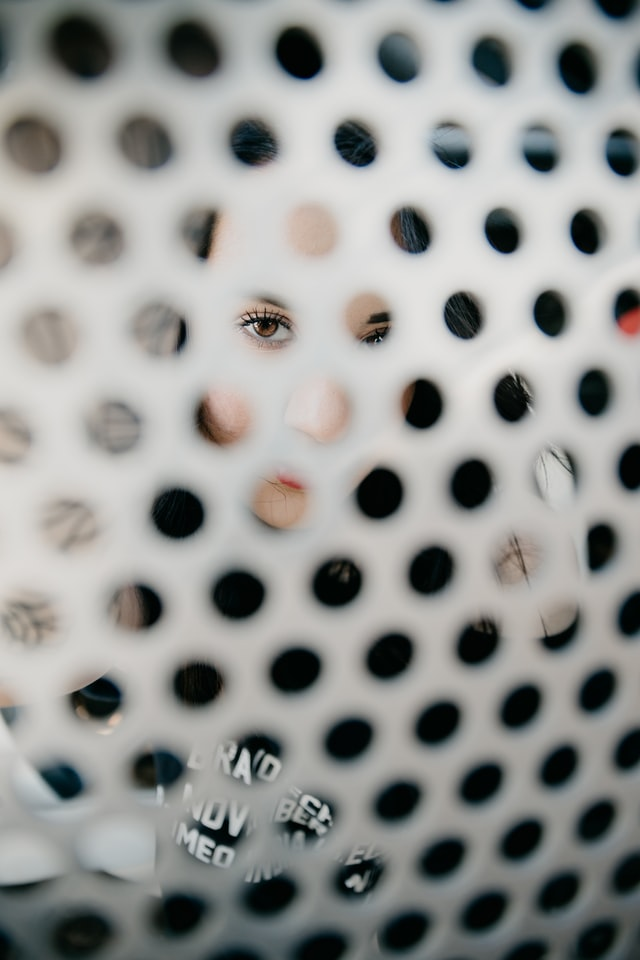
<span><center>Photo by <a href="https://unsplash.com/@luigir?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Luigi</a> on <a href="https://unsplash.com/s/photos/holes?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></center></span>

This notebook intends to compare efficient ways to impute missing values for better model learning.

It is essentially based on the [fancyimpute package](https://github.com/iskandr/fancyimpute) and this [XGBoost prediction notebook](https://www.kaggle.com/nanomathias/xgboost-risk-based-weighted-predictions).

The original XGBoost notebook only tells the model where NaNs are, and does not try to impute them and deal with data as a whole. That is what I will try to do here, hopefully beating the baseline with clever data hole-filling !

The datatable package is useful for reading huge csv quickly. It reduces CPU walltime from 2 minutes to 10 seconds. 

For more on dealing with big data, see [this wonderful notebook](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets).

In [ ]:
import os
path = "../input/janestreetimputeddata/"
for path, directories, files in os.walk(path):
    print(set([(f.split('_', 1)[1][:-4] if 'ive' in f else f.split('_', 1)[0]) for f in files]))

In [ ]:
import pandas as pd
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null
# !pip install datatable
from datatable import fread
import gc
from fancyimpute import *
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xgboost as xgb
import janestreet

Right from the beginning, I will split my data between where feature_0 = +1 and where feature_0 = -1. 

For the reasons of that choice, see the excellent illustrations in the 2 EDA notebooks cited precedently.

In [ ]:
train = fread("../input/jane-street-market-prediction/train.csv").to_pandas().set_index('ts_id', drop=True)
train.drop(columns=[f"resp_{i}" for i in range(1, 5)], inplace=True)
print(f'Done loading data. Train shape is {train.shape}')
train.head()

In [ ]:
TARGET = 'resp'
FEATURES = [f"feature_{i}" for i in range(1, 130)]
train_pos, train_neg = train.loc[train.feature_0 > 0], train.loc[train.feature_0 < 0]
del train
train_pos.drop(columns=[TARGET, 'feature_0'], inplace=True)
train_neg.drop(columns=[TARGET, 'feature_0'], inplace=True)
gc.collect()

# Imputing Data

For this part, I provide the code I used to create the datasets. However it is very long to run so I recommend skipping this part and only reading the final files from [the dataset](https://www.kaggle.com/louise2001/janestreetimputeddata) I published.

In [ ]:
if False:
    y_pos = (train_pos.loc[:, TARGET] > 0).astype(int)
    y_neg = (train_neg.loc[:, TARGET] > 0).astype(int)
    y_pos.to_csv('positive_target.csv')
    y_neg.to_csv('negative_target.csv')
    train_pos[FEATURES].to_csv('positive_original.csv')
    train_neg[FEATURES].to_csv('negative_original.csv')
    def impute_missing(train_, method_name='', method=None):
        for date in tqdm(set(train_.date)):
            pd.DataFrame(method.fit_transform(train_.loc[train_.date==date, FEATURES]), columns=FEATURES).to_csv(f"{method_name}.csv", mode='a', header=False)
    gc.collect()
    for k in (1, 3, 5):
        for train_, sign in zip([train_pos, train_neg], ['positive', 'negative']):
            impute_missing(train_, method_name=f"{sign}_knn_{k}", method=KNN(k=k, verbose=0))
    train_pos[FEATURES].fillna('ffill', axis=0).fillna('bfill', axis=0).to_csv('positive_forward_backward.csv')
    train_neg[FEATURES].fillna('ffill', axis=0).fillna('bfill', axis=0).to_csv('negative_forward_backward.csv')
    for train_, sign in zip([train_pos, train_neg], ['positive', 'negative']):
        impute_missing(train_, method_name=f"{sign}_soft_impute", method=SoftImpute(verbose=0))
    for train_, sign in zip([train_pos, train_neg], ['positive', 'negative']):
        impute_missing(train_, method_name=f"{sign}_iterative_impute", method=IterativeImputer())

# Using the Imputed datasets for prediction

In this part I rely mainly on the XGBoost model from [this notebook](https://www.kaggle.com/nanomathias/xgboost-risk-based-weighted-predictions).

The 2 main differences are :
- I use separate models depending on the sign of *feature_0*
- I use the imputed data from several techniques.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
y_pos = pd.read_csv(path+'positive_target.csv', index_col=0)
y_neg = pd.read_csv(path+'negative_target.csv', index_col=0)

In [ ]:
nan_neg = pd.read_csv(path+"nan_neg.csv", header=None, sep=' ').values.astype(int)
nan_neg.shape

In [ ]:
nan_pos = pd.read_csv(path+"nan_pos.csv", header=None, sep=' ').values.astype(int)
nan_pos.shape

In [ ]:
gc.collect()

In [ ]:
# Split into X and y
from copy import deepcopy as dc
X_pos = dc(train_pos[FEATURES].values)
X_neg = dc(train_neg[FEATURES].values)
del train_pos, train_neg
gc.collect()

In [ ]:
file = 'soft_impute'
X_pos[nan_pos[0], nan_pos[1]] = pd.read_csv(path+f"positive_{file}.csv", header=None, sep=' ').values.flatten()
X_neg[nan_neg[0], nan_neg[1]] = pd.read_csv(path+f"negative_{file}.csv", header=None, sep=' ').values.flatten()

In [ ]:
# Train model
# Parameters from: https://www.kaggle.com/hamditarek/market-prediction-xgboost-with-gpu-fit-in-1min
models = {}
for X, y, sign in zip([X_pos, X_neg], [y_pos.values.flatten(), y_neg.values.flatten()], [+1, -1]):
    print(f"Fitting model for {sign} feature_0")
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=11,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.7,
        random_state=2020,
        tree_method='gpu_hist'
    )
    model.fit(X, y)
    models[sign] = model
    print(f'Finished training model for {sign} feature_0')

# Clear memory
del X_pos, X_neg, y_pos, y_neg
gc.collect()

# Create submission
env = janestreet.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:    
    test_weight, test_sign = test_df.iloc[0].weight, test_df.iloc[0].feature_0
    if test_weight > 0:
        proba = models[test_sign].predict_proba(test_df[FEATURES].values)[0, 1]
        sample_prediction_df.action = int(2 * proba)
    else:
        sample_prediction_df.action = 0
    env.predict(sample_prediction_df)